In [1]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts
import run_expts

#TS Fresh Parameter Settings
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.feature_extraction import extract_features

import matplotlib.patches as mpatches

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))


In [2]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', 500)  # Show rows
pd.set_option('display.max_columns', 160)  # Show columns

In [3]:
folder = '/user/home/ko20929/work/RBD_using_custom_package/Execute New Experiments/Baseline_Extensions/Fitting Hyperparam Test/hyperparameter_tuning_results/'

data_types = ['REM', 'N1', 'N2', 'N3', 'Wake']
models = ['DT' , 'RF' , 'Ada' , 'SVC']
expt_nums = [1,2,3,4]
num_splits_list = [4,5,3]
TS_Fresh_setting, connectivity_setting = 'Minimal' , 'beta'

all_file_names = []
existing_f_names = []
in_prog_f_names = []

for data_type in data_types: 
    for model in models:
        for expt_num in expt_nums:
            for num_splits in num_splits_list:
                file_name = model + '_' + data_type + '_' + TS_Fresh_setting + '_' + connectivity_setting + '_' + 'expt' + str(expt_num) + '_' +  str(num_splits) + '_fold_results_df.pkl'
                all_file_names.append(file_name)
                if os.path.exists(folder + file_name):
                    existing_f_names.append(file_name)
                else:
                    in_prog_f_names.append(file_name)

In [4]:
len(in_prog_f_names)

37

In [5]:
in_prog_f_names

['RF_REM_Minimal_beta_expt4_5_fold_results_df.pkl',
 'RF_N1_Minimal_beta_expt3_4_fold_results_df.pkl',
 'RF_N1_Minimal_beta_expt3_5_fold_results_df.pkl',
 'RF_N1_Minimal_beta_expt4_4_fold_results_df.pkl',
 'RF_N1_Minimal_beta_expt4_5_fold_results_df.pkl',
 'RF_N2_Minimal_beta_expt4_5_fold_results_df.pkl',
 'SVC_N2_Minimal_beta_expt1_4_fold_results_df.pkl',
 'SVC_N2_Minimal_beta_expt1_5_fold_results_df.pkl',
 'SVC_N2_Minimal_beta_expt1_3_fold_results_df.pkl',
 'SVC_N2_Minimal_beta_expt2_4_fold_results_df.pkl',
 'SVC_N2_Minimal_beta_expt2_5_fold_results_df.pkl',
 'SVC_N2_Minimal_beta_expt2_3_fold_results_df.pkl',
 'SVC_N2_Minimal_beta_expt3_4_fold_results_df.pkl',
 'SVC_N2_Minimal_beta_expt3_5_fold_results_df.pkl',
 'SVC_N2_Minimal_beta_expt3_3_fold_results_df.pkl',
 'SVC_N2_Minimal_beta_expt4_4_fold_results_df.pkl',
 'SVC_N2_Minimal_beta_expt4_5_fold_results_df.pkl',
 'SVC_N2_Minimal_beta_expt4_3_fold_results_df.pkl',
 'RF_N3_Minimal_beta_expt4_5_fold_results_df.pkl',
 'SVC_N3_Minimal_b

#### Load one file and explore tuning results

In [6]:
load_path = folder + existing_f_names[2]
results_df = joblib.load(load_path)
results_df = results_df.drop(columns = [col for col in results_df.columns if 'params' in col] +  [col for col in results_df.columns if 'results' in col] )
res_df = run_expts.generate_subset_acc_std(results_df, return_df = True)

acc_df = res_df[[col for col in res_df.columns if 'acc' in col]]
mean_acc_df = pd.DataFrame( acc_df.mean(axis=0) ).T

In [7]:
mean_acc_df

,Prefrontal_DT_acc,Frontal_DT_acc,Left Frontal_DT_acc,Right Frontal_DT_acc,Central_DT_acc,Left Central_DT_acc,Right Central_DT_acc,Left Temporal_DT_acc,Right Temporal_DT_acc,Parietal_DT_acc,Left Parietal_DT_acc,Right Parietal_DT_acc,Occipital_DT_acc
0,0.5,0.325,0.4,0.4375,0.425,0.525,0.45,0.55,0.4375,0.4875,0.5,0.4,0.5125


#### Load all max accuracies from hyperparmeter tuning into a df

In [8]:
max_acc_dict = {}
max_acc_df_cols = ['data_type' , 'model' , 'expt_num' , 'num_splits' , 'max_acc' , 'file_path' ]
for col in max_acc_df_cols: 
    max_acc_dict[col] = []

In [9]:
t1 = time.time()

for data_type in data_types: 
    for model in models:
        for expt_num in expt_nums:
            for num_splits in num_splits_list:
                file_name = model + '_' + data_type + '_' + TS_Fresh_setting + '_' + connectivity_setting + '_' + 'expt' + str(expt_num) + '_' +  str(num_splits) + '_fold_results_df.pkl'
                if os.path.exists(folder + file_name):
                    #Load the file if it exists and calculate maximum accuracy
                    results_df = joblib.load(folder + file_name)
                    results_df = results_df.drop(columns = [col for col in results_df.columns if 'params' in col] +  [col for col in results_df.columns if 'results' in col] )
                    res_df = run_expts.generate_subset_acc_std(results_df, return_df = True)
                    acc_df = res_df[[col for col in res_df.columns if 'acc' in col]]
                    mean_acc_df = pd.DataFrame( acc_df.mean(axis=0) ).T
                    max_acc = mean_acc_df.max(axis = 1)[0]

                    # Populate the dictionary 
                    max_acc_dict['data_type'].append(data_type)
                    max_acc_dict['model'].append(model)
                    max_acc_dict['expt_num'].append(expt_num)
                    max_acc_dict['num_splits'].append(num_splits)
                    max_acc_dict['max_acc'].append(max_acc)
                    max_acc_dict['file_path'].append(folder+file_name)

max_acc_dataframe = pd.DataFrame(max_acc_dict)

t2 = time.time()

t2-t1

31.309821605682373

#### Choose some N1 models to evaluate further

In [18]:
sub_df = max_acc_dataframe[(max_acc_dataframe['data_type'] == 'N1') & (max_acc_dataframe['expt_num'] == 1) & (max_acc_dataframe['num_splits'] == 5)]
sub_df

,data_type,model,expt_num,num_splits,max_acc,file_path
68,N1,Ada,1,5,0.9000,/user/home/ko20929/work/RBD_using_custom_packa...
48,N1,DT,1,5,0.8750,/user/home/ko20929/work/RBD_using_custom_packa...
60,N1,RF,1,5,0.8375,/user/home/ko20929/work/RBD_using_custom_packa...
80,N1,SVC,1,5,0.6000,/user/home/ko20929/work/RBD_using_custom_packa...


In [21]:
list(sub_df.file_path.values)

['/user/home/ko20929/work/RBD_using_custom_package/Execute New Experiments/Baseline_Extensions/Fitting Hyperparam Test/hyperparameter_tuning_results/Ada_N1_Minimal_beta_expt1_5_fold_results_df.pkl',
 '/user/home/ko20929/work/RBD_using_custom_package/Execute New Experiments/Baseline_Extensions/Fitting Hyperparam Test/hyperparameter_tuning_results/DT_N1_Minimal_beta_expt1_5_fold_results_df.pkl',
 '/user/home/ko20929/work/RBD_using_custom_package/Execute New Experiments/Baseline_Extensions/Fitting Hyperparam Test/hyperparameter_tuning_results/RF_N1_Minimal_beta_expt1_5_fold_results_df.pkl',
 '/user/home/ko20929/work/RBD_using_custom_package/Execute New Experiments/Baseline_Extensions/Fitting Hyperparam Test/hyperparameter_tuning_results/SVC_N1_Minimal_beta_expt1_5_fold_results_df.pkl']

In [10]:
max_acc_dataframe = max_acc_dataframe.sort_values(by = ['max_acc'], ascending = False)
max_acc_dataframe.head(15)

,data_type,model,expt_num,num_splits,max_acc,file_path
68,N1,Ada,1,5,0.900000,/user/home/ko20929/work/RBD_using_custom_packa...
47,N1,DT,1,4,0.887500,/user/home/ko20929/work/RBD_using_custom_packa...
67,N1,Ada,1,4,0.875000,/user/home/ko20929/work/RBD_using_custom_packa...
48,N1,DT,1,5,0.875000,/user/home/ko20929/work/RBD_using_custom_packa...
49,N1,DT,1,3,0.875000,/user/home/ko20929/work/RBD_using_custom_packa...
69,N1,Ada,1,3,0.862500,/user/home/ko20929/work/RBD_using_custom_packa...
60,N1,RF,1,5,0.837500,/user/home/ko20929/work/RBD_using_custom_packa...
50,N1,DT,2,4,0.800000,/user/home/ko20929/work/RBD_using_custom_packa...
51,N1,DT,2,5,0.798889,/user/home/ko20929/work/RBD_using_custom_packa...
52,N1,DT,2,3,0.797778,/user/home/ko20929/work/RBD_using_custom_packa...


In [11]:
max_acc_dataframe.iloc[0, :]['file_path']

'/user/home/ko20929/work/RBD_using_custom_package/Execute New Experiments/Baseline_Extensions/Fitting Hyperparam Test/hyperparameter_tuning_results/Ada_N1_Minimal_beta_expt1_5_fold_results_df.pkl'

<Figure size 640x480 with 0 Axes>

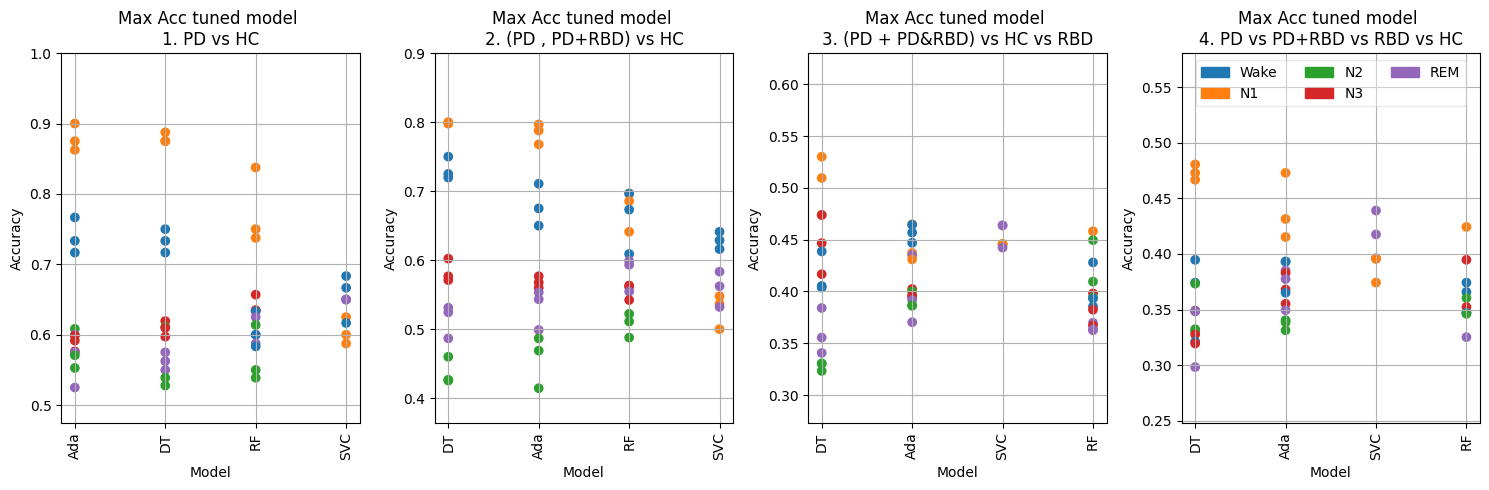

In [12]:
#Do a plot where we have the maximum accuracy y_axis , x_axis is the model , colour is data_type x 4 plots for expt_num
expt_info = [ '1. PD vs HC', '2. (PD , PD+RBD) vs HC', '3. (PD + PD&RBD) vs HC vs RBD', 
             '4. PD vs PD+RBD vs RBD vs HC' ]

results_df = max_acc_dataframe

fig = plt.figure()
fig = plt.figure(figsize=(15,5),dpi=100)

for i in [1,2,3,4]:
    expt_num = i
    expt_results = results_df[results_df['expt_num'] == expt_num].copy()
    
    ax = fig.add_subplot(1,4,i)
    
    plt.title('Max Acc tuned model \n' + expt_info[expt_num-1])
    
    #Define colours for the different data types
    colors = {'Wake':'tab:blue', 'N1':'tab:orange', 'N2':'tab:green', 'N3':'tab:red', 'REM':'tab:purple'}
    plt.scatter(expt_results['model'].values, expt_results['max_acc'].values,
                    c = expt_results['data_type'].map(colors)) 
   
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.ylim((expt_results['max_acc'].min() - 0.05 , expt_results['max_acc'].max() + 0.1))
    plt.grid()

    plt.tight_layout()

#Custom Legend, because standard legend wouldn't work for some reason
patches = []
for key, val in colors.items():
    patches.append(mpatches.Patch(color= val, label=key) )

# plt.legend(handles=patches, framealpha = 0.1)
plt.legend(loc = 'upper center', ncol = 3 ,  handles=patches, framealpha = 0.4)
    
plt.tight_layout()

#### Load Wake Experiment 1 to investigate

In [15]:
wake_df = results_df[results_df['data_type'] == 'Wake']
wake_df_1 = wake_df[wake_df['expt_num'] == 1]
wake_df_1

,data_type,model,expt_num,num_splits,max_acc,file_path
185,Wake,Ada,1,4,0.766667,/user/home/ko20929/work/RBD_using_custom_packa...
163,Wake,DT,1,3,0.750000,/user/home/ko20929/work/RBD_using_custom_packa...
161,Wake,DT,1,4,0.733333,/user/home/ko20929/work/RBD_using_custom_packa...
186,Wake,Ada,1,5,0.733333,/user/home/ko20929/work/RBD_using_custom_packa...
187,Wake,Ada,1,3,0.716667,/user/home/ko20929/work/RBD_using_custom_packa...
162,Wake,DT,1,5,0.716667,/user/home/ko20929/work/RBD_using_custom_packa...
197,Wake,SVC,1,4,0.683333,/user/home/ko20929/work/RBD_using_custom_packa...
199,Wake,SVC,1,3,0.666667,/user/home/ko20929/work/RBD_using_custom_packa...
175,Wake,RF,1,3,0.633333,/user/home/ko20929/work/RBD_using_custom_packa...
198,Wake,SVC,1,5,0.616667,/user/home/ko20929/work/RBD_using_custom_packa...


In [ ]:
'Prefrontal_DT_acc'

In [82]:
results_df_DT = joblib.load(wake_df_1.loc[69,'file_path']) 
results_df = results_df_DT.drop(columns = [col for col in results_df_DT.columns if 'params' in col] +  [col for col in results_df_DT.columns if 'results' in col] )
res_df = run_expts.generate_subset_acc_std(results_df, return_df = True)

acc_df = res_df[[col for col in res_df.columns if 'acc' in col]]

In [91]:
DT_scores = pd.concat([results_df_DT['Prefrontal_DT_cv_results'][0] , results_df_DT['Prefrontal_DT_cv_results'][1] ] ) 
DT_scores.iloc[: , 6:].sort_values(by = 'mean_test_score', ascending = False)

,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,fold
25,1,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.875,1.000,0.875,0.916667,0.058926,1,5
22,3,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.875,1.000,0.875,0.916667,0.058926,1,5
43,5,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.875,1.000,0.875,0.916667,0.058926,1,5
42,3,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.875,1.000,0.875,0.916667,0.058926,1,5
40,1,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.875,1.000,0.875,0.916667,0.058926,1,5
38,5,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.875,1.000,0.875,0.916667,0.058926,1,5
32,3,"{'criterion': 'entropy', 'max_depth': 2, 'min_...",0.875,1.000,0.875,0.916667,0.058926,1,5
31,2,"{'criterion': 'entropy', 'max_depth': 2, 'min_...",0.875,1.000,0.875,0.916667,0.058926,1,5
30,1,"{'criterion': 'entropy', 'max_depth': 2, 'min_...",0.875,1.000,0.875,0.916667,0.058926,1,5
28,5,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.875,1.000,0.875,0.916667,0.058926,1,5
